# Coverage and usage of broadband services in the UK

## Introduction

This notebook explores the coverage and usage of fixed (i.e. not mobile) broadband services in the UK using a dataset published by Ofcom (the UK regulatory and competition authority for the telecoms, broadcasting and postal sectors).

To inform its annual ['Connected Nations'](https://www.ofcom.org.uk/research-and-data/multi-sector-research/infrastructure-research) report Ofcom collects data from fixed telecoms providers on the predicted connection speed available over their networks to all residential and small business premises in the UK. It also collects data for all of these premises in relation to the actual connection speed of the active service and monthly data usage. Fortunately for us, Ofcom shares all of this data online aggregated by postcode and by local authority. We will be analysing the most recent data which was collected in May and June 2017 and is available [here](https://www.ofcom.org.uk/research-and-data/multi-sector-research/infrastructure-research/connected-nations-2017/data-downloads). 

*Note: if you are viewing this notebook directly on Github rather than via nbviewer.jupyter.org please [click here](https://nbviewer.jupyter.org/github/nickconvery/uk-broadband/blob/master/Coverage%20and%20usage%20of%20broadband%20services%20in%20the%20UK.ipynb) to be redirected so that Javascript elements (interactive broadband coverage maps) will be rendered below. Please also note that these elements may not be rendered if you are using Microsoft's Edge or Internet Explorer browsers. If so, please use an alternative browser if you wish to see these elements.*


## Technical background

Before we import the dataset and begin our analysis let's first take a brief technical detour.

Ofcom defines **superfast** and **ultrafast** broadband services as connections capable of supporting download speeds of at least **30Mbit/s** and **300Mbit/s** respectively. We will be using these same definitions throughout this notebook. Superfast and ultrafast broadband services can be delivered using a variety of technologies which we discuss below.

There are two main fixed broadband networks in the UK which are operated by Openreach and Virgin Media.

Openreach is the division of BT that is responsible for operating its access network. This refers to the 'last mile' of wires connecting BT's local exchanges and street cabinets to homes and businesses. Telecoms providers such as BT Retail, Sky and TalkTalk are able to provide retail broadband services by connecting their own networks to BT's local exchanges and using Openreach's network to carry traffic over the last mile to end-users' premises (the price that these providers, including BT Retail, pay to Openreach is set by Ofcom as part of its three-yearly Wholesale Local Access market review).

Historically, the lines from BT's local exchanges to its street cabinets and onwards to end-user premises were made entirely of copper. Since 2010, Openreach has been upgrading its network by deploying fibre-to-the-cabinet (FTTC) which involves replacing the copper line between a local exchange and street cabinet with optical fibre which supports higher connection speeds than copper. Openreach then typically uses VDSL (very-high-bitrate digital subscriber line) technology in the street cabinet to support the delivery of superfast broadband services over the remaining copper line to an end-user's premises. Since 2016, Openreach has also been trialling the use of its G.fast technology in place of VDSL which supports the delivery of ultrafast broadband services over the remaining copper line (with download speeds of up to 330Mbit/s). Openreach has also deployed fibre-to-the-premises (FTTP i.e. optical fibre used all the way up to an end-user's premises) in limited areas such as to new-build housing developments. FTTP can be used to deliver both superfast and ultrafast broadband services.

Virgin Media operates its own 'cable' network which it alone uses to provide retail broadband, telephony and pay TV services. Construction of the network was started in the 1980s and 1990s by NTL and Telewest and it therefore pre-dates the availability of superfast and ultrafast broadband services (NTL and Telewest later merged in 2006 and rebranded as Virgin Media in 2007 following their acquisition of Virgin Mobile). However, the network was initially designed to carry not just telephony signals but also the high-bandwidth television signals that make up a cable TV subscription. The network therefore used optical fibre all the way up to the street cabinet and then a co-axial copper cable - which is capable of delivering today's ultrafast broadband services - running from the street cabinet to the end-user's premises. In 2015 Virgin Media launched its Project Lightning initiative which aims to extends its network to pass 4 million additional premises by 2020. During this new network rollout Virgin Media is connecting some premises with optical fibre from the street cabinet instead of co-axial copper cable. 

Beyond Openreach and Virgin Media, a number of telecoms providers have built their own smaller yet growing competing networks that are capable of delivering superfast and ultrafast broadband services. These include providers such as CityFibre, Gigaclear and Hyperoptic each with their own FTTP networks as well as providers such as Relish and Quickline which use Fixed Wireless technology (i.e. the airwaves) in the access portion of their networks.

## The data

### Importing the data

First, let's import the various Python libraries that we will be using and configure some settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import zipfile
import requests
from io import BytesIO
import os, glob, tempfile
%matplotlib inline
pd.options.display.float_format = '{:,.1f}'.format

As discussed above, Ofcom collects broadband coverage and usage data from telecoms providers for the roughly 26 million residential and small business premises in the UK. It shares two versions of this data aggregated either by postcode or by local authority (there are ~1.6 million postcodes and 391 local authorities in the UK). We will use the more granular postcode dataset when exploring monthly data usage. We will be creating interactive maps to explore the coverage data and so will also use the local authority dataset due to the difficulty of rendering 1.6 million postcode boundaries within a browser. 

The following code downloads the two datasets from the links provided on Ofcom's [website](https://www.ofcom.org.uk/research-and-data/multi-sector-research/infrastructure-research/connected-nations-2017/data-downloads) and reads them into two pandas DataFrames (*pc* for postcode and *la* for local authority). The postcode dataset is in the form of a compressed .zip folder containing a .csv file for each of the 121 postcode areas in the UK. We extract these .csv files to a temporary folder, read them one-by-one into DataFrames and then append these together to arrive at a DataFrame with data for all postcodes. The local authority dataset is in the form of a single .csv file and so can be loaded directly to a DataFrame.

In [2]:
request = requests.get('https://www.ofcom.org.uk/static/research/connected-nations2017/fixed-postcode-2017.zip')
zip_file = zipfile.ZipFile(BytesIO(request.content))
temp_dir = tempfile.mkdtemp()

with zip_file:
    zip_file.extractall(temp_dir)
    
all_files = glob.glob(os.path.join(temp_dir, "*.csv"))

pc_temp = (pd.read_csv(f) for f in all_files)
pc = pd.concat(pc_temp, ignore_index=True)

pc.head()

,postcode,postcode_space,postcode area,SFBB availability (% premises),UFBB availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Median download speed (Mbit/s),...,Number of connections 5<10 Mbit/s (number of lines),Number of connections 10<30 Mbit/s (number of lines),Number of connections >= 30 Mbit/s (number of lines),Number of connections >= 300 Mbit/s (number of lines),Average data usage (GB),Average data usage (GB) for lines <10Mbit/s,Average data usage (GB) for Basic BB lines,Average data usage (GB) for SFBB lines,Average data usage (GB) for UFBB lines,FTTP availability (% premises)
0,AB101AL,AB10 1AL,AB,100,0,0,0,0,0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
1,AB101AN,AB10 1AN,AB,100,0,0,0,0,0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2,AB101AP,AB10 1AP,AB,100,0,0,0,0,0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
3,AB101AS,AB10 1AS,AB,0,0,0,0,0,100,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
4,AB101AU,AB10 1AU,AB,0,0,0,0,0,100,16.0,...,2.0,23.0,0.0,0.0,161.4,379.6,161.4,0.0,0.0,0


In [3]:
la = pd.read_csv('https://www.ofcom.org.uk/__data/assets/file/0021/108831/fixed-local-authority-2017.csv')
la.head()

,laua,laua_name,SFBB availability (% premises),UFBB availability (% premises),FTTP availability (% premises),% of premises unable to receive 2Mbit/s,% of premises unable to receive 5Mbit/s,% of premises unable to receive 10Mbit/s,% of premises unable to receive 30Mbit/s,Median download speed (Mbit/s),...,Number of connections 2<5 Mbit/s (number of lines),Number of connections 5<10 Mbit/s (number of lines),Number of connections 10<30 Mbit/s (number of lines),Number of connections >= 30 Mbit/s (number of lines),Number of connections >= 300 Mbit/s (number of lines),Average data usage (GB),Average data usage (GB) for lines <10Mbit/s,Average data usage (GB) for Basic BB lines,Average data usage (GB) for SFBB lines,Average data usage (GB) for UFBB lines
0,S12000033,Aberdeen City,90,0,0,0,1,2,9,17.5,...,7006,15993,35257,32941,45,191.8,115.8,157.1,254.4,0.0
1,S12000034,Aberdeenshire,72,0,0,4,9,14,26,16.6,...,10023,21211,34149,30087,0,161.3,91.2,126.4,241.6,0.0
2,E07000223,Adur,29,70,0,0,0,0,1,50.0,...,672,2232,6381,14536,72,178.7,107.4,154.8,192.8,450.0
3,E07000026,Allerdale,86,1,1,2,6,8,13,18.9,...,3791,4831,13395,13219,0,161.8,74.0,122.9,231.6,0.0
4,E07000032,Amber Valley,87,1,0,1,2,3,12,18.7,...,4319,7781,15380,16401,6,183.5,97.5,141.6,255.8,165.3


### Preparing the data

We have a little bit of processing to do before the data is ready for analysis. First, the variables names are very descriptive (although Ofcom also publish documentation for the [postcode](https://www.ofcom.org.uk/__data/assets/pdf_file/0028/108829/about-data-fixed-postcode-2017.pdf) and [local authority](https://www.ofcom.org.uk/__data/assets/pdf_file/0027/108828/about-data-fixed-local-unitary-authority-2017.pdf) datasets) but we will want to reference them using shorthand in our analysis. Let's rename the variables in both the postcode and local authority DataFrames as follows:

- **postcode / local authority**: The postcode / local authority
- **sfbb_cov**: Superfast broadband availability (>30Mbit/s download speed) (% premises)
- **ufbb_cov**: Ultrafast broadband availability (>300Mbit/s download speed) (% premises)
- **fttp_cov**: Fibre-to-the-premise (FTTP) availability (% premises)
- **sub_2mbit_cov**: % of premises unable to receive 2Mbit/s download speed
- **sub_5mbit_cov**: % of premises unable to receive 5Mbit/s download speed
- **sub_10mbit_cov**: % of premises unable to receive 10Mbit/s download speed
- **sub_30mbit_cov**: % of premises unable to receive 30Mbit/s download speed
- **dl_med**: Median download speed (Mbit/s)
- **dl_mean**: Average download speed (Mbit/s)
- **dl_min**: Minimum download speed (Mbit/s)
- **dl_max**: Maximum download speed (Mbit/s)
- **dl_sub10**: Average download speed (Mbit/s) for lines <10Mbit/s download speed
- **dl_sub30**: Average download speed (Mbit/s) for lines <30Mbit/s download speed
- **dl_over30**: Average download speed (Mbit/s) for lines >30Mbit/s download speed
- **dl_over300**: Average download speed (Mbit/s) for lines >300Mbit/s download speed
- **ul_med**: Median upload speed (Mbit/s)
- **ul_mean**: Average upload speed (Mbit/s)
- **ul_min**: Minimum upload speed (Mbit/s)
- **ul_max**: Maximum upload speed (Mbit/s)
- **ul_sub10**: Average upload speed (Mbit/s) for lines <10Mbit/s download speed
- **ul_sub30**: Average upload speed (Mbit/s) for lines <30Mbit/s download speed
- **ul_over30**: Average upload speed (Mbit/s) for lines >30Mbit/s download speed
- **ul_over300**: Average upload speed (Mbit/s) for lines >300 Mbit/s download speed
- **lines_sub2**: Number of connections <2 Mbit/s (number of lines)
- **lines_2to5**: Number of connections 2<5 Mbit/s (number of lines)
- **lines_5to10**: Number of connections 5<10 Mbit/s (number of lines)
- **lines_10to30**: Number of connections 10<30 Mbit/s (number of lines)
- **lines_over30**: Number of connections >30 Mbit/s (number of lines)
- **lines_over300**: Number of connections >300 Mbit/s (number of lines)
- **usage_mean**: Average data usage (GB) (upload and download)
- **usage_sub10**: Average data usage (GB) (upload and download) for lines <10Mbit/s download speed
- **usage_sub30**: Average data usage (GB) (upload and download) for lines <30Mbit/s download speed
- **usage_over30**: Average data usage (GB) (upload and download) for lines >30Mbit/s download speed
- **usage_over300**: Average data usage (GB) (upload and download) for lines >300Mbit/s download speed

In [4]:
dflist = [pc, la]

varnames = {
 'SFBB availability (% premises)': 'sfbb_cov',
 'UFBB availability (% premises)': 'ufbb_cov',
 'FTTP availability (% premises)': 'fttp_cov',
 '% of premises unable to receive 2Mbit/s': 'sub_2mbit_cov',
 '% of premises unable to receive 5Mbit/s': 'sub_5mbit_cov',
 '% of premises unable to receive 10Mbit/s': 'sub_10mbit_cov',
 '% of premises unable to receive 30Mbit/s': 'sub_30mbit_cov',
 'Median download speed (Mbit/s)': 'dl_med',
 'Average download speed (Mbit/s)': 'dl_mean',
 'Minimum download speed (Mbit/s)': 'dl_min',
 'Maximum download speed (Mbit/s)': 'dl_max',
 'Average download speed (Mbit/s) for lines  < 10Mbit/s': 'dl_sub10',
 'Average download speed (Mbit/s) for Basic BB lines': 'dl_sub30',
 'Average download speed (Mbit/s) for SFBB lines': 'dl_over30',
 'Average download speed (Mbit/s) for UFBB lines': 'dl_over300',
 'Median upload speed (Mbit/s)': 'ul_med',
 'Average upload speed (Mbit/s)': 'ul_mean',
 'Minimum upload speed (Mbit/s)': 'ul_min',
 'Maximum upload speed (Mbit/s)': 'ul_max',
 'Average upload speed (Mbit/s) for lines <10Mbit/s': 'ul_sub10',
 'Average upload speed (Mbit/s) for Basic BB lines': 'ul_sub30',
 'Average upload speed (Mbit/s) for SFBB lines': 'ul_over30',
 'Average upload speed (Mbit/s) for UFBB lines': 'ul_over300',
 'Number of connections < 2 Mbit/s  (number of lines)': 'lines_sub2',
 'Number of connections 2<5 Mbit/s  (number of lines)': 'lines_2to5',
 'Number of connections 5<10 Mbit/s  (number of lines)': 'lines_5to10',
 'Number of connections 10<30 Mbit/s  (number of lines)': 'lines_10to30',
 'Number of connections >= 30 Mbit/s  (number of lines)': 'lines_over30',
 'Number of connections >= 300 Mbit/s  (number of lines)': 'lines_over300',
 'Average data usage (GB)': 'usage_mean',
 'Average data usage (GB) for lines <10Mbit/s': 'usage_sub10',
 'Average data usage (GB) for Basic BB lines': 'usage_sub30',
 'Average data usage (GB) for SFBB lines': 'usage_over30',
 'Average data usage (GB) for UFBB lines': 'usage_over300'
}

for df in dflist:
    df.rename(columns = varnames, inplace=True)

Next, in the raw data superfast and ultrafast broadband coverage are mutually exclusive. In other words, if a premise can receive ultrafast broadband (>300Mbit/s) then it is not counted as being able to receive superfast broadband (>30Mbit/s). We will update the superfast broadband coverage variable so that it instead includes all premises able to receive a download speed of at least 30Mbit/s (rather than only between 30 and 300Mbit/s).

In [5]:
for df in dflist:
    df['sfbb_cov'] = df['sfbb_cov'] + df['ufbb_cov']

We will generate a new variable with the total number of lines within each postcode or local authority using the breakdown of the number of lines by connection speed. We will also generate some further breakdowns of lines by connection speed that align with the breakdowns provided for average monthly data usage in the raw data (e.g. we have average data usage for sub-10Mbit/s lines but not a corresponding count of the number of sub-10Mbit/s lines).

In [6]:
for df in dflist:
    df['lines_total'] = df.lines_sub2 + df.lines_2to5 + df.lines_5to10 + df.lines_10to30 + df.lines_over30
    df['lines_sub10'] = df.lines_sub2 + df.lines_2to5 + df.lines_5to10
    df['lines_sub30'] = df.lines_sub2 + df.lines_2to5 + df.lines_5to10 + df.lines_10to30
    df['lines_30to300'] = df.lines_over30 - df.lines_over300

In the raw data the breakdown of average data usage by connection speed is zero even when there are no lines with the relevant connection speed within the postcode or local authority. We will replace these entries with NaN values to indicate that these measures are not applicable when there are no corresponding lines.

In [7]:
for df in dflist:
    df.loc[df.lines_sub10==0,'usage_sub10'] = np.nan
    df.loc[df.lines_sub30==0,'usage_sub30'] = np.nan
    df.loc[df.lines_over30==0,'usage_over30'] = np.nan
    df.loc[df.lines_over300==0,'usage_over300'] = np.nan

There is some overlap in the breakdowns of average data usage by connection speed. We want to separate average data usage into that for: 0-10Mbit/s lines, 10-30Mbit/s lines, 30-300Mbit/s lines and >300Mbit/s lines. We can work out the missing variables (average data usage for 10-30Mbit/s and 30-300Mbit/s lines) by decomposing the relevant weighted averages (pandas will automatically generate NaNs where there are no 10-30Mbit/s or 30-300Mbit/s lines).

In [8]:
for df in dflist:
    df['usage_10to30'] = (df.usage_sub30 * df.lines_sub30 - df.usage_sub10 * df.lines_sub10)/df.lines_10to30
    df['usage_30to300'] = (df.usage_over30 * df.lines_over30 - df.usage_over300 * df.lines_over300)/df.lines_30to300

In decomposing the weighted averages we end up generating a small number of negative values in the postcode DataFrame (<0.01%  of observations). This appears to be caused by the rounding to 1 decimal place of average data usage in the raw data which can cause negative values in the above calculations when dealing with the relatively small number of lines within a postcode (the local authority DataFrame is not affected). We will drop these observations.

In [9]:
(pc[['usage_sub10', 'usage_sub30', 'usage_over30', 'usage_over300','usage_10to30', 'usage_30to300']] < 0).sum()

usage_sub10         0
usage_sub30         0
usage_over30        0
usage_over300       0
usage_10to30     2907
usage_30to300    1881
dtype: int64

In [10]:
pc.drop(pc[(pc.usage_10to30 < 0) | (pc.usage_30to300 < 0)].index, inplace=True)

## Analysis

### Lines per postcode and per local authority

Let's check how many postcodes and local authorities we are working with (remembering that we dropped ~5k observations from the postcode dataset).

In [11]:
print('Postcodes: ', len(pc.index))
print('Local authorities: ', len(la.index))

Postcodes:  1609005
Local authorities:  391


In the postcode dataset, if there are fewer than 4 premises in a postcode then Ofcom only publishes coverage data and redacts all data relating to the active service on the line (e.g. number of lines by connection speed, data usage) to preserve anonymity. We can see below that this affects roughly 280k postcodes.

In [12]:
len(pc.index) - pc.usage_mean.count()

283009

The average number of lines per postcode is 17 (for those postcodes where the breakdown of lines by connection speed is unredacted, allowing us to generate the total number of lines). A box plot shows that this distribution is right-skewed with two postcodes even having over 400 lines.

In [13]:
pc['lines_total'].mean()

17.33246706626566

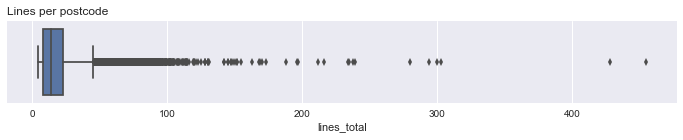

In [14]:
plt.figure(figsize=(12,1.5))
pc_lines = sns.boxplot(x=pc.lines_total, orient='h');
pc_lines.set_title('Lines per postcode', loc='left');

The average number of lines per local authority is 60k. A box plot shows that this distribution is also (less severely) right-skewed.

In [15]:
la['lines_total'].mean()

60219.3273657289

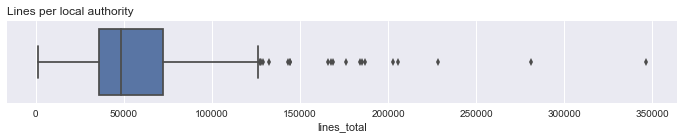

In [16]:
plt.figure(figsize=(12,1.5))
la_lines = sns.boxplot(x=la.lines_total, orient='h');
la_lines.set_title('Lines per local authority', loc='left');

### Broadband coverage data

What percentage of premises in the UK were able to receive superfast, ultrafast and FTTP broadband services as of mid-2017?

In [17]:
coverage = la[['sfbb_cov', 'ufbb_cov', 'fttp_cov']].apply(lambda x: x * la.lines_total/la.lines_total.sum()).sum().to_frame()
coverage.rename(columns={0: 'National coverage (% premises)'}, inplace=True)
coverage

,National coverage (% premises)
sfbb_cov,91.2
ufbb_cov,36.6
fttp_cov,2.8


Let's see how availability of these services varies across the UK. Economic theory tells us that there is likely to be a stronger case for commercial investment in the infrastructure required to deliver faster broadband services in areas with relatively high population density. This is because the fixed cost of the investment (e.g. replacing the copper line between an exchange and cabinet with optical fibre) can be recovered across a greater number of potential customers. 

We'll be using the brilliant [folium](https://github.com/python-visualization/folium) library which allows us to generate interactive [Leaflet.JS](http://leafletjs.com/) maps from the comfort of Python. The function below takes a DataFrame of UK local authority IDs and associated data as an input and uses folium to generate a map where each local authority is shaded based on its value in a specified column (this is called a 'choropleth' map).

*Note: if you are viewing this notebook directly on Github rather than via nbviewer.jupyter.org please [click here](https://nbviewer.jupyter.org/github/nickconvery/uk-broadband/blob/master/Coverage%20and%20usage%20of%20broadband%20services%20in%20the%20UK.ipynb) to be redirected so that Javascript elements (interactive broadband coverage maps) will be rendered below. Please also note that these elements may not be rendered if you are using Microsoft's Edge or Internet Explorer browsers. If so, please use an alternative browser if you wish to see these elements.*

In [18]:
def la_choropleth(df, col_la, col_data, **kwargs):
    """Generates a choropleth map of UK local authority areas.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with at least two columns: UK local authority IDs and associated data
    col_la : str
        Column label containing UK local authority IDs (format: E, W, S or N followed by 8 digits)
    col_data : str
        Column label containing data used to shade local authorities
    **kwargs
        Arguments to pass to folium's Map.choropleth function

    Returns
    -------
    folium.Map
        A folium Map object with UK local authorities shaded according to associated values of 'col_data'
    """
    
    la_boundaries = 'shapes/la_uk_simplified.json'
    
    la_map = folium.Map(location=[55.3, -3], zoom_start = 5, width='55%', height='100%')
    
    la_map.choropleth(geo_data=open(la_boundaries), data=df, columns=[col_la, col_data], key_on='feature.properties.la_code', 
                topojson='objects.la_uk_simplified', fill_color='BuPu', fill_opacity=0.8, line_color='black', line_weight=0.2,
                **kwargs)
    
    return la_map

#### Superfast broadband coverage (>30Mbit/s)

We saw above that 91.2% of premises nationally were able to receive superfast broadband services as of mid-2017. The economic theory discussed above is borne out in the map below which shows that coverage tends to be higher in relatively more densely populated local authority areas. 

It is often argued that increased availability and quality of broadband services is important both to the economy but also society more generally. In light of this, and the fact that pure commercial rollout is likely to leave some areas lagging significantly behind, public funding has been made available with the aim of reducing the gap in coverage between rural and urban areas (e.g. various programmes under the [Government's Broadband Delivery UK (BDUK)](https://www.gov.uk/guidance/broadband-delivery-uk#superfast-broadband-programme) initiative).

In [19]:
la_choropleth(la, 'laua', 'sfbb_cov', legend_name='Superfast broadband coverage (>30Mbit/s) (% premises)')

#### Ultrafast broadband coverage (>300Mbit/s)

National coverage of ultrafast broadband services was 36.6% as of mid-2017. The map below shows how this varies by local authority. Ofcom gathers data from each provider and in its [full report](https://www.ofcom.org.uk/__data/assets/pdf_file/0017/108512/connected-nations-fixed-broadband-2017.pdf) it explains that national coverage of ultrafast broadband services is largely driven by Virgin Media's cable network. This is because even the largest FTTP network of any other single provider covers just 1.2% of premises. In addition, Openreach's use of G.fast technology in its street cabinets to deliver ultrafast broadband services over copper remains at the pilot stage.

In [20]:
la_choropleth(la, 'laua', 'ufbb_cov', legend_name='Ultrafast broadband coverage (>300Mbit/s) (% premises)')

#### Fibre-to-the-premises (FTTP) broadband coverage

National coverage of FTTP - a technology that can be used to deliver both superfast and ultrafast broadband services - was 2.8% as of mid-2017. A number of providers have built their own FTTP networks in different parts of the country. The chart below recreates Figure 8 of Ofcom's [full report](https://www.ofcom.org.uk/__data/assets/pdf_file/0017/108512/connected-nations-fixed-broadband-2017.pdf) which provides a breakdown of national coverage by provider.

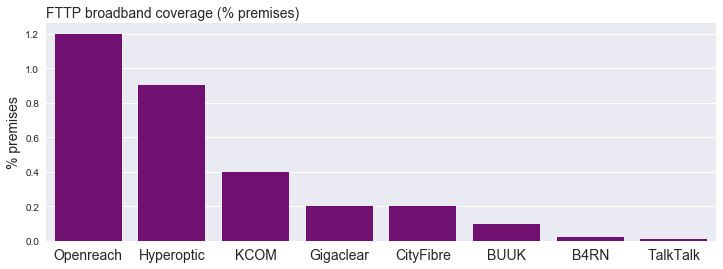

In [21]:
plt.figure(figsize=(12,4))
fttp = pd.Series({'Openreach': 1.2, 'Hyperoptic': 0.9, 'KCOM': 0.4, 'CityFibre': 0.2, 
                       'Gigaclear': 0.2, 'BUUK': 0.1, 'B4RN': 0.02, 'TalkTalk': 0.01})
fttp.sort_values(ascending=False, inplace=True)
fig = sns.barplot(x=fttp.index, y = fttp, color='purple')
fig.set_title('FTTP broadband coverage (% premises)', fontsize=14, loc='left')
fig.set_ylabel('% premises', fontsize=14);
fig.set_xticklabels(labels=fttp.index, fontsize=14);

The map below shows how coverage of FTTP broadband services varies by local authority. In the vast majority of local authority areas coverage is less than 10% (and in most cases 1% or below). The local authority with the highest FTTP coverage is Bournemouth (57%) where [CityFibre](https://www.cityfibre.com/) has built an extensive network which [Gigler](http://gigler.co.uk/) uses to provide retail FTTP broadband services. This is followed by the city of Hull (45%) and the surrounding East Riding of Yorkshire (34%) area where [KCOM](https://www.kcomhome.com/) (rather than BT) is the incumbent telecoms provider. KCOM has focussed on deploying FTTP instead of FTTC when upgrading its copper network. In doing so it has prioritised a relatively slower and more costly, yet ultimately more future-proof, rollout of ultrafast broadband instead of superfast broadband. Another local authority area that stands out on the map is Cornwall (29%) driven by the emphasis on deploying FTTP as part of the [Superfast Cornwall](https://www.superfastcornwall.org/) programme (funded by Cornwall Council, BT and the EU).

In [22]:
la_choropleth(la, 'laua', 'fttp_cov', legend_name='FTTP broadband coverage (% premises)')

### Active broadband service data

In addition to the predicted connection speed that is available over a provider's network to all premises in the UK, Ofcom also collects data in relation to the active service for all premises where a provider has customers. This includes the actual tested download speed of the service to which the customer is subscribed as well as the amount of data used per month (in Gigabytes, GB).

#### Download speed of active service

When aggregating and summarising the premise-level data by postcode and local authority Ofcom groups lines into fairly broad groups by download speed. The table below shows the most granular breakdown of lines by download speed that is available. We can see that take-up of superfast broadband services (roughly 48%) appears to be significantly lower than the coverage of these services (which, as above, is roughly 91%).

In [23]:
lines = la[['lines_sub2', 'lines_2to5', 'lines_5to10', 'lines_10to30', 'lines_30to300', 'lines_over300']].apply(
    lambda x: 100 * x/la.lines_total.sum()).sum().to_frame()

lines.rename(columns={0: '%'}, inplace=True)
lines

,%
lines_sub2,2.4
lines_2to5,7.7
lines_5to10,14.2
lines_10to30,27.1
lines_30to300,48.4
lines_over300,0.2


#### Monthly data usage of active service

Let's draw a box plot to visualise the distribution of monthly data usage per line across postcodes (upload and download combined).

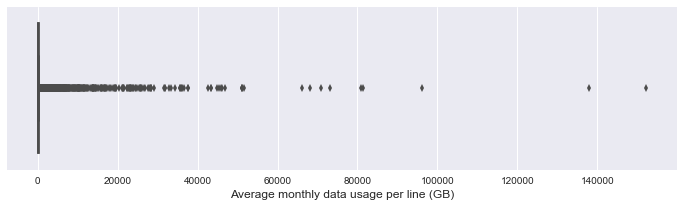

In [24]:
plt.figure(figsize=(12,3))
sns.set_style('darkgrid')
fig = sns.boxplot(data=pc.loc[:,['usage_mean']], orient='h');
fig.set_xlabel('Average monthly data usage per line (GB)', fontsize=12);
fig.yaxis.set_visible(False)

It looks like we have a lot of outliers or extreme values. There are various plausible reasons for this. The outliers may represent postcodes where one or more premises are genuinely very intensive users (e.g. small businesses in the technology sector). Alternatively, there could perhaps be intermittent errors in the systems monitoring data usage over lines. If we were performing analysis to understand or predict the relationship between data usage and other variables (e.g. a regression analysis) then it would be important for us to investigate this further. However, here we are primarily concerned with visualising the data. As we can see above, outliers make it very difficult for us to visualise the distribution of the vast majority of (non-outlier) observations and so we would like to remove them from our dataset.

There are various procedures to detect outliers in a dataset, all of which try to measure the extent to which the value of an observation deviates from some measure of the central or average value. A common procedure is to classify any observation with a value that is further than 3 standard deviations from the mean as an outlier. However, this is not a robust procedure for detecting outliers as the mean and standard deviation of a sample are measures which are themselves heavily influenced by the presence of outliers. In the function below we use an alternative and robust procedure for outlier detection which is based on the sample median and [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation).

In [25]:
def removeOutliers(df, col):
    """Removes outlier observations for a specified column label from a DataFrame using median absolute deviation
    
    Parameters
    ----------
    df : DataFrame
    col: str
        The column label to be used to classify outliers in the DataFrame

    Returns
    -------
    DataFrame
        Where rows that are outliers based on the specified column label are removed
    
    """
    med = df[col].median()
    mad = df[col].mad()
    return df.loc[(df[col] > med - 3*mad) & (df[col] < med + 3*mad), :]

Let's draw a box plot and histogram to visualise the distribution of monthly data usage per line across postcodes after outlier observations have been removed from the DataFrame using the function defined above. We can see that the median monthly data usage per line is roughly 160GB and the maximum is just over 400GB (as opposed to 150,000GB in the full dataset including outliers).

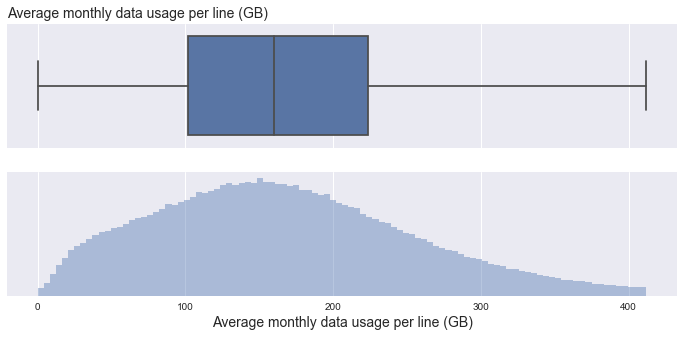

In [26]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5), sharex=True)

sns.boxplot(data=removeOutliers(pc,'usage_mean'), x = 'usage_mean', ax=ax1, orient='h', whis=10);
sns.distplot(removeOutliers(pc,'usage_mean')['usage_mean'], ax=ax2, bins=100, kde=False);

ax1.set_title('Average monthly data usage per line (GB)', fontsize=14, loc='left')
ax2.set_xlabel('Average monthly data usage per line (GB)', fontsize=14)
ax1.set_xlabel('')
ax2.yaxis.set_visible(False)

Does monthly data usage vary by connection speed? 

The box plot and histogram below plot monthly data usage per line broken down by the broad groupings of connection speed provided in the raw data. We can see that median monthly data usage (as well as the lower and upper bounds of the interquartile range) increases each time as we step from looking at sub-10Mbit/s lines through to 10-to-30Mbit/s lines and again through to 30-to-300Mbit/s lines. 

The distribution of monthly data usage for ultrafast broadband (>300Mbit/s) lines is noticeably wider than for the other groups. Median monthly data usage for ultrafast broadband lines (~150GB) is in fact lower than for superfast broadband lines (~190GB) and similar to that for 10-to-30Mbit/s broadband lines (~150GB). However, there are also (proportionally) more premises that consume lots of data with ultrafast broadband compared to other speeds as indicated by the fact that ultrafast broadband lines have the highest upper quartile threshold for monthly data usage.

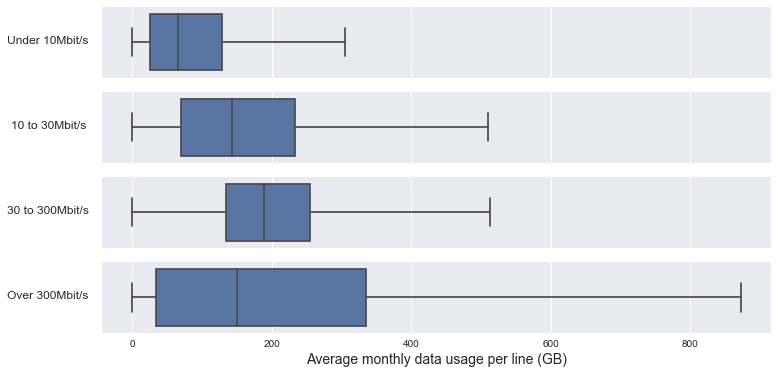

In [27]:
varlist = ['usage_sub10', 'usage_10to30', 'usage_30to300', 'usage_over300']

vardict = {'usage_sub10': 'Under 10Mbit/s', 'usage_10to30': '10 to 30Mbit/s', 
           'usage_30to300': '30 to 300Mbit/s', 'usage_over300': 'Over 300Mbit/s'}

fig, axs = plt.subplots(4, figsize=(12,6), sharex=True)

for i, ax in enumerate(fig.axes):   
    sns.boxplot(ax = ax, x=removeOutliers(pc, varlist[i])[varlist[i]], orient='h', whis=10);
    axs[i].set_xlabel('')
    axs[i].set_title(vardict[varlist[i]], y=0.4, x=-0.08)
axs[-1].set_xlabel('Average monthly data usage per line (GB)', fontsize=14);

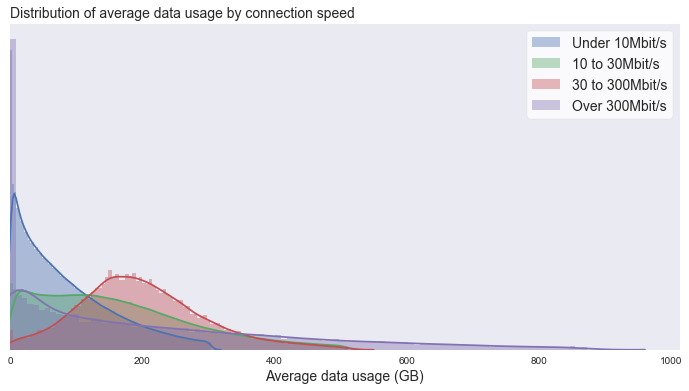

In [28]:
plt.figure(figsize=(12,6))
sns.set_style('dark')

for var in varlist:
    fig =  sns.distplot(removeOutliers(pc, var)[var], label=vardict[var],bins=100, kde=True, norm_hist=True);
    
fig.set_title('Distribution of average data usage by connection speed', fontsize=14, loc='left')
fig.set_xlabel('Average data usage (GB)', fontsize=14)
fig.legend(fontsize=14, frameon=True, facecolor='white')
fig.yaxis.set_visible(False)
fig.set_xlim(xmin=0);

Does monthly data usage increase if we look at more granular increases in connection speed? 

Unfortunately we do not have the premise-level data to directly compare average monthly data usage between, for instance, 30Mbit/s and 10Mbit/s lines. However, as shown below, we are able to plot average monthly data usage within a postcode against the average download speed across all premises within a postcode (noting that averaging within a postcode may affect the relationship; for instance there may be postcodes with a 50:50 split between basic sub-30Mbit/s broadband and ultrafast broadband lines). 

We can see that average monthly data usage within a postcode tends to increase with average download speed until a threshold of around 25Mbit/s. After this, average monthly data usage appears to level off at around 180GB independent of average download speed. There are various plausible explanations for this observation. On the one hand, it is possible that lower download speeds actually constrain data usage. For instance, premises with low download speeds would like to use HD streaming services but find their connection cannot adequately support them. Alternatively, it may also be that there are simply underlying differences in the types of premises that are likely to buy higher speed broadband services. For instance, premises with a stronger preference for using HD streaming services are more likely to buy a superfast broadband service.

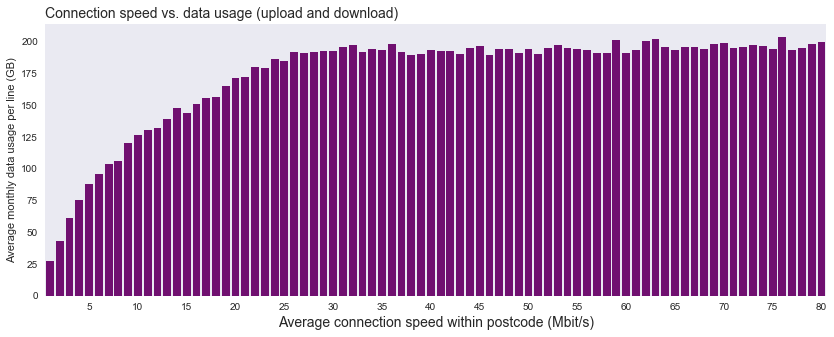

In [29]:
pc['speed'] = pd.cut(pc['dl_mean'], bins=[x for x in range(81)])

plt.figure(figsize=(14,5))
sns.set_style('dark')
fig = sns.barplot(x=pc.groupby('speed')['usage_mean'].mean().index, y=pc.groupby('speed')['usage_mean'].mean(), color='purple')

fig.set_title('Connection speed vs. data usage (upload and download)', loc='left', fontsize='14')
fig.set_ylabel('Average monthly data usage per line (GB)')
fig.set_xlabel('Average connection speed within postcode (Mbit/s)', fontsize='14')
fig.set_xticklabels([x if x%5 == 0 else '' for x in range (1,81)], rotation='horizontal');

## Opportunities for further study

We have seen above how the coverage and usage of broadband services varies across the UK. An interesting line of further inquiry would be to perform a regression analysis to investigate the relationship between various factors and either broadband coverage or monthly data usage. For instance, one could investigate whether the density and make-up (e.g. age profile) of the local population has a statistically significant impact on either broadband coverage or monthly data usage.